## Accessing Data in Cloud-Optimized GeoTIFFs (COGs) with R

Cloud-Optimized GeoTIFFs (COGs) address the challenges of working with large geospatial datasets, particularly in cloud environments. They enable efficient, scalable workflows for geospatial analysis and are increasingly used in remote sensing and GIS.

### Key Benefits of COGs:

- **Subset Access**: Access specific regions or bands of data without downloading the entire file. This capability is critical when working with large, high-resolution datasets.

- **Cloud-Native Efficiency**: COGs use HTTP range requests to fetch only the necessary byte ranges from cloud-hosted files. This minimizes bandwidth usage and speeds up processing.

- **Cost Savings**: By avoiding full downloads, COGs help reduce storage and data transfer costs, which is especially important when using pay-as-you-go cloud services.

- **Faster Workflows**: On-demand data access improves the speed of tasks such as visualization, analysis, and processing, making workflows more responsive and scalable.

- **Interoperability**: COGs are supported by a wide range of geospatial tools and libraries, making them easy to integrate into diverse workflows.

---

### Demonstration Goals:

This notebook will showcase how COGs enable efficient geospatial data access in R by:

1. **Accessing a cloud-hosted COG directly** via its `vsis3` URL (see the [GDAL virtual filesystem docs](https://gdal.org/en/stable/user/virtual_file_systems.html) for more).
2. **Reading and visualizing small subsets** of the data (1/100th portions) without downloading the entire file.
3. **Stitching adjacent subsets together** to confirm spatial continuity and demonstrate seamless access to neighboring regions.

Through these steps, we showcase how COGs enable efficient and cost-effective geospatial workflows directly in R.

In [11]:
# the only library we'll need is terra
library(terra)

# We have to let AWS know that this is an anonymous request; we can do this with an environment variable
Sys.setenv(AWS_NO_SIGN_REQUEST = "YES")

# Define the COG URL using its virtual filesystem address
# This is the vsi equivalent of 's3://sentinel-cogs/sentinel-s2-l2a-cogs/12/R/UU/2024/4/S2A_12RUU_20240421_0_L2A/B02.tif'
cog_url <- "/vsis3/sentinel-cogs/sentinel-s2-l2a-cogs/12/R/UU/2024/4/S2A_12RUU_20240421_0_L2A/B02.tif"

# Open the COG and inspect metadata
# Take note: `rast` *does not* download the file: We are only creating a reference to it here!
r <- rast(cog_url)
# Without downloading any of the pixel-data, we still have access to information from the header:
print(r)


class       : SpatRaster 
dimensions  : 10980, 10980, 1  (nrow, ncol, nlyr)
resolution  : 10, 10  (x, y)
extent      : 3e+05, 409800, 3290220, 3400020  (xmin, xmax, ymin, ymax)
coord. ref. : WGS 84 / UTM zone 12N (EPSG:32612) 
source      : B02.tif 
name        : B02 


### Extracting and Visualizing the First Subset (Top-Left 1/100th)

In this step, we extract the top-left 1/100th portion of the dataset by calculating its geographic extent based on pixel indices. This highlights the benefit of **subset access** provided by Cloud-Optimized GeoTIFFs (COGs), which allows us to access only the portion of the data we need.

#### Steps Performed:
1. **Calculate the Resolution**:
   The pixel resolution in the x and y directions is obtained from the raster properties.

2. **Determine the Subset Size**:
   - The total number of columns and rows in the raster is divided by 10 to define a 1/10th portion in each direction.
   - The pixel indices for the top-left 1/100th region are then mapped to geographic coordinates.

3. **Create an Extent**:
   Using the calculated coordinates, an extent is defined for the subset. Terra's `crop` method wants a spatial extent, so this translation is important!

4. **Crop the Raster**:
   The raster is cropped to this extent, retrieving only the specified subset.

5. **Visualize the Subset**:
   The cropped subset is plotted, showcasing just the top-left portion of the raster.

This demonstrates extracting and visualizing small portions of a much larger dataset without accessing unnecessary data.

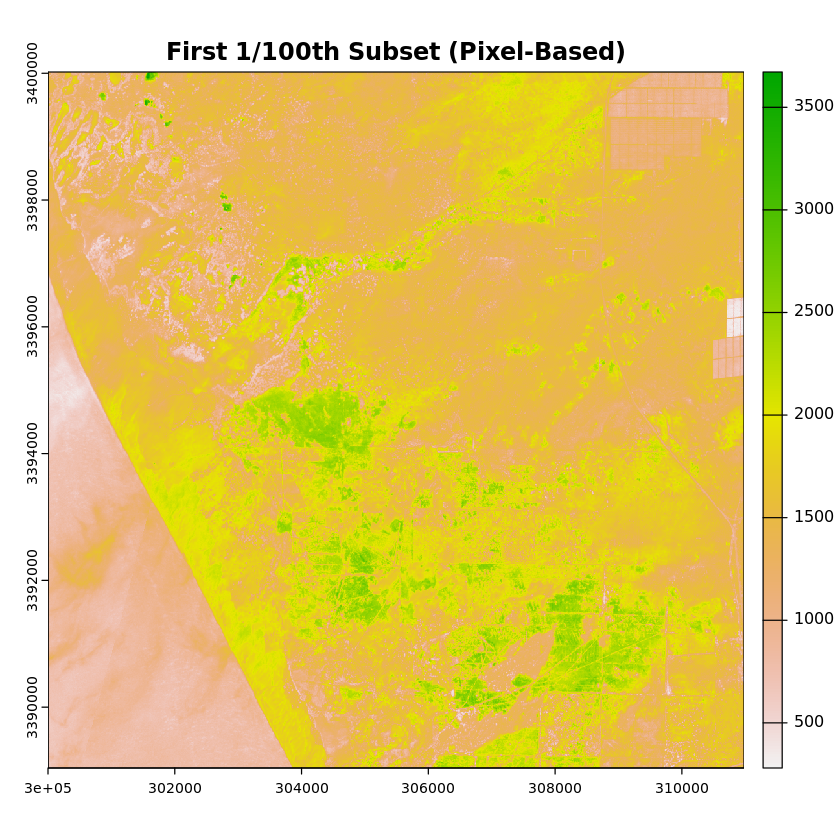

In [8]:
# Get raster properties
res_x <- res(r)[1]  # Resolution in x-direction
res_y <- res(r)[2]  # Resolution in y-direction

# Define the pixel ranges for the top-left 1/100th
n_cols <- ncol(r) / 10
n_rows <- nrow(r) / 10

# Convert pixel indices to geographic coordinates
xmin <- xmin(r) + (0 * res_x)
xmax <- xmin(r) + (n_cols * res_x)
ymax <- ymax(r) - (0 * res_y)
ymin <- ymax(r) - (n_rows * res_y)

# Create an extent from the pixel-based coordinates
extent_1 <- ext(xmin, xmax, ymin, ymax)

# Crop the raster using the extent
subset_1 <- crop(r, extent_1)
plot(subset_1, main = "First 1/100th Subset (Pixel-Based)")

### Extracting and Visualizing the Second Subset (Adjacent 1/100th to the Right)

Here, we extract the second 1/100th portion of the dataset, which is directly adjacent to the first subset in the x-direction. By calculating the extent for this region and cropping the raster, we demonstrate the seamless access to neighboring regions in a Cloud-Optimized GeoTIFF (COG).

#### Key Steps:
1. **Shift the Extent Horizontally**:
   - The x-coordinate range is shifted by one 1/10th portion to the right, while the y-coordinates remain unchanged.

2. **Crop the Raster**:
   The raster is cropped to this new extent, retrieving only the data for the adjacent region.

3. **Visualize the Subset**:
   The cropped subset is plotted, showing the region immediately to the right of the first subset.

This kind of workflow makes it possible to process large rasters in smaller, more manageable pieces.

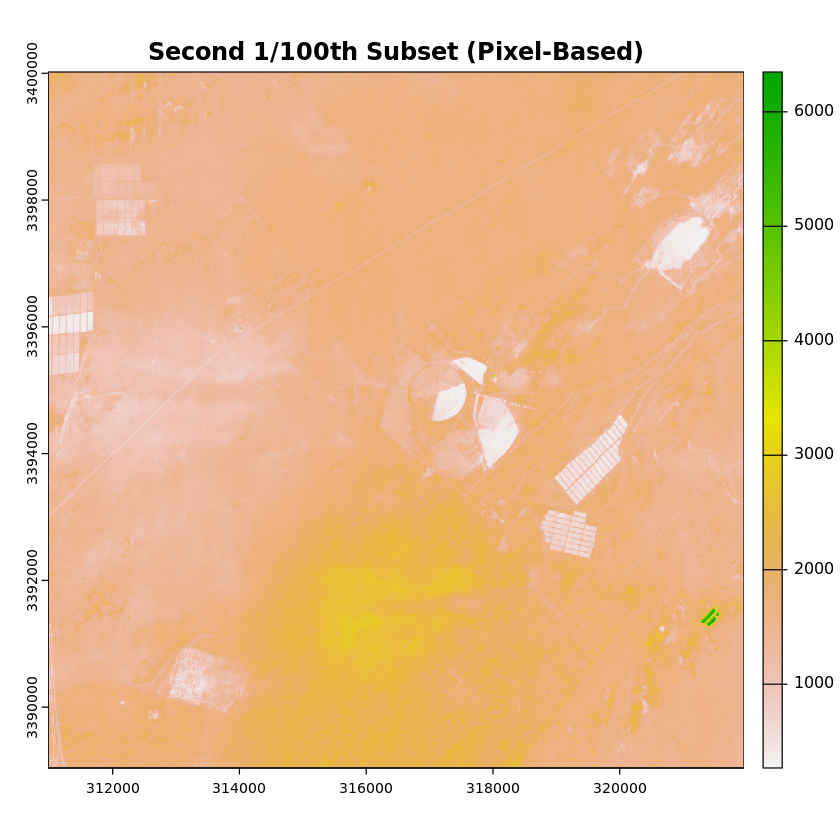

In [9]:
# Define the pixel ranges for the second 1/100th (to the right)
xmin_2 <- xmin(r) + (n_cols * res_x)
xmax_2 <- xmin(r) + (2 * n_cols * res_x)

# Create the extent for the second subset
extent_2 <- ext(xmin_2, xmax_2, ymin, ymax)

# Crop the raster for the second subset
subset_2 <- crop(r, extent_2)
plot(subset_2, main = "Second 1/100th Subset (Pixel-Based)")

### Merging and Visualizing Stitched Subsets

In our final step, we combine the two adjacent subsets (the top-left 1/100th and the next 1/100th to the right) into a single raster. This operation demonstrates the **spatial continuity** of the data and confirms that the subsets align seamlessly.

#### Key Steps:
1. **Merge the Subsets**:
   The two cropped subsets are merged into a single raster, ensuring that their spatial alignment is preserved.

2. **Visualize the Stitched Raster**:
   The merged raster is plotted, showing both subsets together as one continuous region.

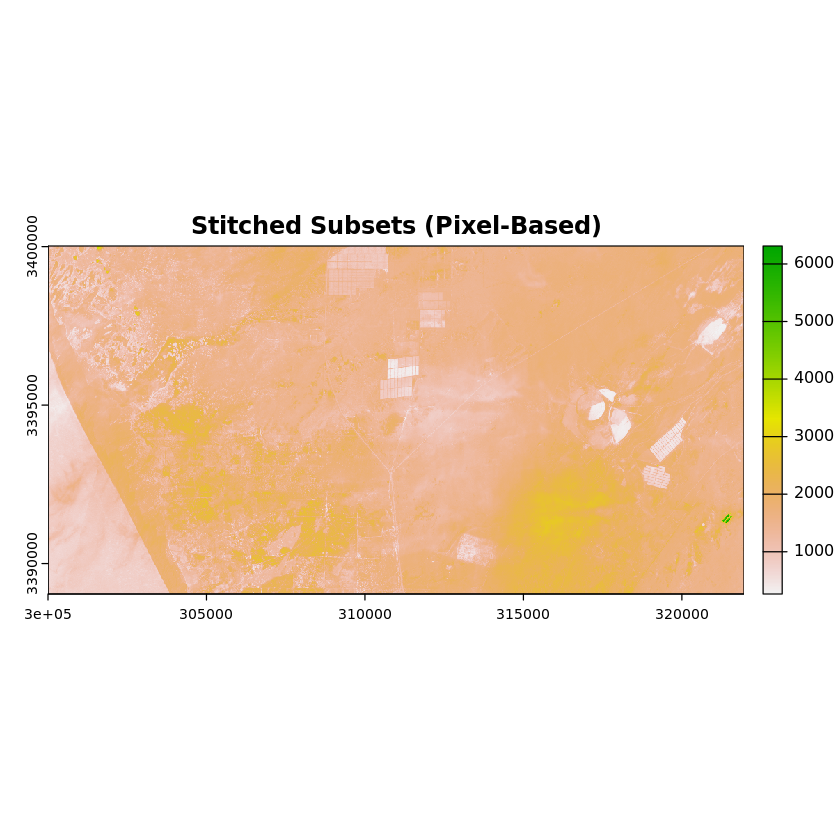

In [10]:
# Merge the two subsets
stitched <- merge(subset_1, subset_2)
plot(stitched, main = "Stitched Subsets (Pixel-Based)")

## Review of Key Points

In this notebook, we demonstrated how to efficiently access and process geospatial data stored in a **Cloud-Optimized GeoTIFF (COG)** using `terra` in R. The key takeaways include:

1. **Efficient Data Access**:
   - COGs allow on-demand access to specific subsets of a dataset without requiring the download of the entire file.
   - This capability reduces bandwidth usage, speeds up workflows, and supports scalable analysis of large datasets.

2. **Subset Extraction**:
   - Two adjacent 1/100th subsets of the dataset were defined and accessed:
     - The top-left region.
     - The region immediately to its right.
   - Subsets were extracted by defining geographic extents derived from pixel indices, showcasing precise control over data access.

3. **Seamless Stitching**:
   - The two subsets were merged to confirm their spatial adjacency and continuity.
   - This demonstrated how small portions of a dataset can be combined for analysis without accessing the full raster.

4. **Reflection on Tools**:
   - The `terra` package provides a powerful interface for geospatial data processing in R, offering methods to crop, merge, and visualize raster data.